## IMPORTS

In [4]:
!pip install torch>=2.0.0 torchvision>=0.15.0 lightning>=2.0.0 torchmetrics>=0.11.4 \
hydra-core==1.3.2 hydra-colorlog==1.2.0 hydra-optuna-sweeper==1.2.0 \
mlflow opencv-python Pillow ultralytics tifffile \
rootutils pre-commit rich pytest tqdm pandas



In [5]:
import tifffile
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import SAM
from pathlib import Path
# from codecarbon import EmissionsTracker
from datetime import datetime
import csv

In [6]:
tif_path = 'Romane_Martin_urne_sature_10-4.tif'

## PARAMETRES

In [21]:

GRID_STRIDE   = 64                   # densité des points
POINTS_PER_CALL = 30                # taille des chunks envoyés à SAM
MIN_AREA      = 300                  # aire min d’un masque (en pixels)
CONF_THR      = 0.5                 #  seuil min confiance de SAM
DEDUP_IOU_THR = 0.90                 # seuil de dé-duplication
MIN_MASK_REGION_AREA = 200
IMAGE_3D_PATH = tif_path
SAM_WEIGHTS = "sam_b.pt"   #path sam en local ou bien download from ultralytics
POINT_LABEL = 1


## UTILS

In [22]:
#detection urne par seuillage
def get_urna_mask_threshold(img_gray, thr=60):
    """
    img_gray : [H, W]
    Retourne un masque booléen [H, W]
    """
    if img_gray.ndim != 2:
        raise ValueError(f"get_urna_mask_threshold attend une image 2D grayscale, reçu shape={img_gray.shape}")

    urna_mask = img_gray >= thr
    return urna_mask


In [23]:
# Génération de points en grille
def make_grid_points(h, w, stride, label=1):
    xs = np.arange(stride // 2, w, stride)
    ys = np.arange(stride // 2, h, stride)
    pts = [(int(x), int(y)) for y in ys for x in xs]  # (x, y)
    return pts

In [24]:
# Colorisation des masques pour affichage
def colorize_masks(image, masks_bool, seed=42):
    img = np.asarray(image)
    if img.ndim == 2:
        out = np.dstack([img, img, img]).astype(np.uint8, copy=False)
    elif img.ndim == 3 and img.shape[2] == 3:
        out = img.astype(np.uint8, copy=False).copy()
    else:
        raise ValueError(f"image must be [H,W] or [H,W,3], got {img.shape}")
    H, W = out.shape[:2]
    rng = np.random.default_rng(seed)
    for m in masks_bool:
        m = np.asarray(m, dtype=bool)
        if m.shape != (H, W):
            raise ValueError(f"mask shape {m.shape} != {(H,W)}")
        color = rng.integers(0, 256, size=3, dtype=np.uint8)
        out[m] = color
    return out

## Préparation des données


In [25]:
# exemple extraction slice au milieu
vol = tifffile.imread(IMAGE_3D_PATH)
print(f"Volume: shape={vol.shape}, dtype={vol.dtype}")
mid = len(vol) // 2
sl  = vol[mid]

Volume: shape=(1735, 1808, 1595), dtype=uint8


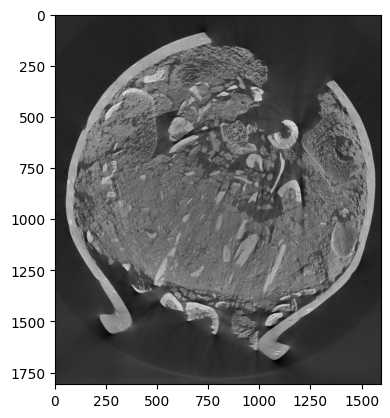

In [26]:
plt.imshow(sl, cmap="gray")
plt.show()

### Pré-traitement et préparation de l'image pour SAM

In [27]:
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
def apply_clahe(sl, use_clahe=True):
    sl_prep=sl.copy()
    if use_clahe:
        sl_prep = clahe.apply(sl_prep)
    return sl_prep  # [H,W]

def convert_rgb(picture_3D: np.ndarray) -> np.ndarray:
    # convert [H,W] en  [H,W,3]
    return np.repeat(picture_3D[..., np.newaxis], 3, -1)

In [28]:
img_rgb  = convert_rgb(sl)         # [H,W,3]

print("img_rgb:", img_rgb.shape, img_rgb.dtype)

img_rgb: (1808, 1595, 3) uint8


### detection de  l'urne

(np.float64(-0.5), np.float64(1594.5), np.float64(1807.5), np.float64(-0.5))

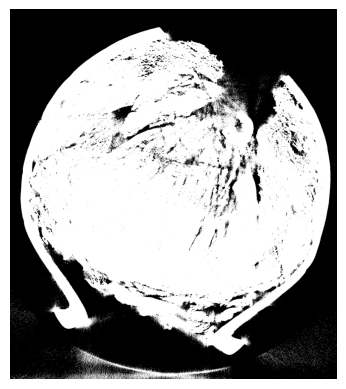

In [29]:
urna_mask = get_urna_mask_threshold(sl, thr=60)
plt.imshow(urna_mask, cmap="gray")
plt.axis("off")

##  SAM Model

In [30]:
import torch
print(torch.__version__)
print(torch.version.cuda) 
print(torch.cuda.device_count())


2.9.1+cu130
13.0
1


In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if not Path(SAM_WEIGHTS).exists():
    print(f"Downloading {SAM_WEIGHTS}...")
    model = SAM(SAM_WEIGHTS)
else:
    print(f"{SAM_WEIGHTS} already exists locally")
    model = SAM(SAM_WEIGHTS)

print("SAM chargé")

Device: cpu
SAM chargé


### Start emission tracker

In [ ]:
tracker = EmissionsTracker()
tracker.start()


[codecarbon WARNING @ 13:41:11] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:41:11] [setup] RAM Tracking...
[codecarbon INFO @ 13:41:11] [setup] CPU Tracking...
[codecarbon WARNING @ 13:41:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 13:41:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 13:41:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 13:41:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:41:12] [setup] GPU Tracking...
[codecarbon INFO @ 13:41:12] No GPU found.
[codecarbon INFO @ 13:41:12] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

# Inference

In [32]:
import numpy as np
import torch

def sam_inference(
    model,
    img_rgb,                   # image rgb [H,W,3]
    urna_mask,                 # masque booléen [H,W] ou None
    mode="grid",               # grid, auto ou points
    # paramètres prompts
    grid_stride=64, points=None, labels=None,
    # paramètres SAM
    device="cuda", imgsz=640, iou=0.25, max_det=100, conf=0.75,
    # paramètres filtrage
    min_area=300, max_area_ratio=0.05,
    # colorisation des masques
    make_colored=True, color_seed=0):

    if img_rgb.ndim != 3 or img_rgb.shape[2] != 3:
        raise ValueError(f"img rgb  doit être RGB [H,W,3]  {img_rgb.shape}")

    H, W, _ = img_rgb.shape

    # gray image pour la colorisation
    img_gray = img_rgb[..., :3].mean(axis=2).astype(np.uint8)

    img_area = H*W
    max_area = int(max_area_ratio * img_area)

    if urna_mask is not None:
        urna_mask = urna_mask.astype(bool)
        if urna_mask.shape != (H, W):
            raise ValueError(f"urna_mask doit être de taille {(H,W)} reçu {urna_mask.shape}")

    # Préparation des prompts
    filtered_points = None
    filtered_labels = None

    if mode == "grid":
        pts= make_grid_points(H, W, grid_stride)

        if urna_mask is None:
            filtered_points = pts
        else:
            filtered_points = [(x, y) for (x, y) in pts if urna_mask[y, x]]

        filtered_labels = [1] * len(filtered_points)

        if len(filtered_points) == 0:
            colored = np.dstack([img_gray]*3).astype(np.uint8)
            return [], colored, {"mode": "grid", "n_masks_raw": 0,
                                 "n_masks_filtered": 0, "n_points": 0}

    elif mode == "points":
        if points is None:
            raise ValueError("mode='points' mais aucun points fourni")
        filtered_points = points
        filtered_labels = labels if labels is not None else [1]*len(points)

    elif mode == "auto":
        filtered_points = None
        filtered_labels = None

    else:
        raise ValueError("mode doit être 'grid', 'auto' ou 'points'")

    with torch.inference_mode():
        if filtered_points is not None:
            results = model(
                img_rgb,
                points=filtered_points,
                labels=filtered_labels,
                device=device,
                imgsz=imgsz,
                iou=iou,
                max_det=max_det,
                conf=conf,
                agnostic_nms=True,
                show=False,
            )
        else:
            results = model(
                img_rgb,
                device=device,
                imgsz=imgsz,
                iou=iou,
                max_det=max_det,
                conf=conf,
                agnostic_nms=True,
                show=False,
            )

    res = results[0]

    if res.masks is None:
        colored = np.dstack([img_gray] * 3).astype(np.uint8)
        return [], colored, {"mode": mode, "n_masks_raw": 0,"n_masks_filtered": 0, "n_points": 0}

    masks = res.masks.data.cpu().numpy().astype(np.uint8)
    masks = np.squeeze(masks)

    if masks.ndim == 2:
        masks = masks[None, ...]

    print(f"[{mode}] masks brutes detectés", masks.shape)

    if urna_mask is None:
        print("[INFO] Pas de masque d’urne fourni : aucun filtrage appliqué.")
        filtered_masks = (masks > 0)

        # Colorisation
        colored = colorize_masks(img_gray, filtered_masks, seed=color_seed) if make_colored else None

        return list(filtered_masks), colored, {
            "mode": mode,
            "n_masks_raw": int(masks.shape[0]),
            "n_masks_filtered": int(filtered_masks.shape[0]),
            "n_points": 0 if filtered_points is None else len(filtered_points),
            "min_area": min_area,
            "max_area": max_area,
        }


    # Restreindre les masques à l’intérieur de l’urne
    masks = np.array([(m > 0) & urna_mask for m in masks], dtype=bool)

    # Filtrage par aire
    areas = np.array([m.sum() for m in masks])
    keep_idx = np.where((areas >= min_area) & (areas <= max_area))[0]
    filtered_masks = masks[keep_idx]

    print(f"[{mode}] masks filtrés", filtered_masks.shape)

    # Colorisation
    if make_colored:
        if filtered_masks.size == 0:
            colored = np.dstack([img_gray] * 3).astype(np.uint8)
        else:
            colored = colorize_masks(img_gray, filtered_masks, seed=color_seed)
    else:
        colored = None

    # Informations pour debug
    info = {
        "mode": mode,
        "n_masks_raw": int(masks.shape[0]),
        "n_masks_filtered": int(filtered_masks.shape[0]),
        "n_points": 0 if filtered_points is None else len(filtered_points),
        "min_area": min_area,
        "max_area": max_area,
    }

    return list(filtered_masks), colored, info



0: 640x640 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 38987.4ms
Speed: 8.1ms preprocess, 38987.4ms inference, 60.3ms postprocess per image at shape (1, 3, 640, 640)
[auto] masks brutes detectés (23, 1808, 1595)
[auto] masks filtrés (22, 1808, 1595)
{'mode': 'auto', 'n_masks_raw': 23, 'n_masks_filtered': 22, 'n_points': 0, 'min_area': 300, 'max_area': 144188}


(np.float64(-0.5), np.float64(1594.5), np.float64(1807.5), np.float64(-0.5))

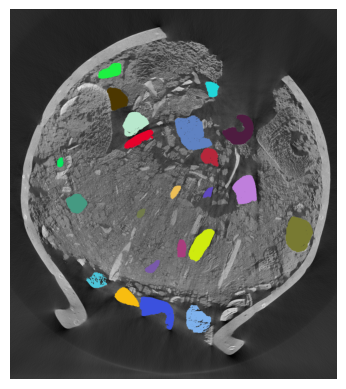

In [33]:
masks_auto, colored_auto, info_auto = sam_inference(
    model,
    urna_mask=urna_mask,
    img_rgb=img_rgb,
    mode="auto",
    device=device,
    imgsz=640,
    iou=0.25,
    max_det=100,
    conf=0.75,
    min_area=300,
    max_area_ratio=0.05,
)
print(info_auto)
plt.imshow(colored_auto)
plt.axis("off")


In [34]:
import torch
print("CUDA dispo :", torch.cuda.is_available())
print("Nb GPU :", torch.cuda.device_count())
print("Nom :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA dispo : False
Nb GPU : 0
Nom : None



0: 640x640 1 2, 1 5, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 15, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 25, 1 33, 1 34, 1 35, 1 38, 1 41, 1 44, 1 45, 1 46, 1 49, 1 50, 1 58, 1 59, 1 63, 1 64, 1 65, 1 67, 1 72, 1 75, 1 78, 1 79, 1 82, 1 83, 1 87, 1 89, 1 90, 1 92, 1 93, 1 94, 1 96, 1 97, 1 98, 1 100, 1 101, 1 105, 1 110, 1 111, 1 113, 1 114, 1 115, 1 117, 1 118, 1 119, 1 120, 1 126, 1 128, 1 131, 1 133, 1 139, 1 141, 1 144, 1 145, 1 153, 1 154, 1 155, 1 158, 1 164, 1 166, 1 170, 1 171, 1 174, 1 176, 1 178, 1 179, 1 180, 1 181, 1 189, 1 190, 1 193, 1 194, 1 199, 1 200, 1 201, 1 202, 1 203, 1 204, 1 205, 1 206, 1 207, 1 208, 1 209, 1 210, 1 212, 1 214, 1 215, 1 219, 1 223, 1 224, 1 225, 1 226, 1 227, 1 228, 1 229, 1 231, 1 232, 1 238, 1 239, 1 241, 1 242, 1 243, 1 246, 1 247, 1 248, 1 249, 1 250, 1 252, 1 253, 1 254, 1 256, 1 257, 1 263, 1 264, 1 269, 1 270, 1 272, 1 273, 1 274, 1 276, 1 277, 1 278, 1 279, 1 282, 1 283, 1 284, 1 287, 1 290, 1 293, 1 294, 1 296, 1 297, 1 299, 1 301, 1 302

(np.float64(-0.5), np.float64(1594.5), np.float64(1807.5), np.float64(-0.5))

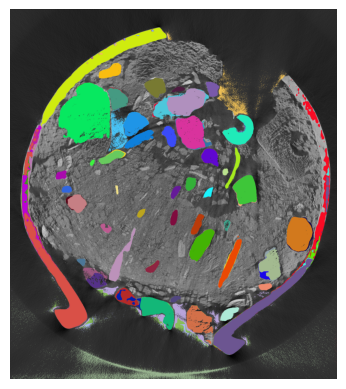

In [37]:
masks_grid, colored_grid, info_grid = sam_inference(
    model,
    img_rgb=img_rgb,
    urna_mask=urna_mask,
    mode="grid",
    device=device,
    grid_stride=60,
    imgsz=640,
    iou=0.25,
    max_det=100,
    conf=0.75,
    min_area=0,
    max_area_ratio=0.02
)
print(info_grid)
plt.imshow(colored_grid)
plt.axis("off")


### Save codecarbon results and stop tracking

In [ ]:
emissions = tracker.stop()
print("Emissions (kg CO2eq) :", emissions)

In [ ]:
with open("emissions.csv", "a", newline="") as f:
    writer = csv.writer(f)
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    writer.writerow([timestamp, emissions])
